In [359]:
import torch

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [360]:
def model(t_u, w, b):
    return w * t_u + b # weight * x + bias => line

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [361]:
# let's start predict...
w = torch.ones(())  # scalar => 0 dimensions tensor
b = torch.zeros(()) # scalar => 0 dimensions tensor

t_p = model(t_u, w, b)
loss = loss_fn(t_p, t_c)
loss  # really big error...we need to adjust w and b using gradient descent

tensor(1763.8848)

In [371]:
# check on which side (add delta or subtract delta) we improve our loss (decrease) and adjust parameters according to this
delta = 0.1

loss_rate_of_change_w = (loss_fn(model(t_u, w+delta, b), t_c) - 
                         loss_fn(model(t_u, w-delta, b), t_c)) / (2.0 * delta)

learning_rate = 2e-5

w = w - learning_rate * loss_rate_of_change_w

loss_rate_of_change_b = (loss_fn(model(t_u, w, b+delta), t_c) - 
                         loss_fn(model(t_u, w, b-delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b

t_p = model(t_u, w, b)
loss = loss_fn(t_p, t_c)
loss

tensor(170.9948)

In [387]:
# instead to compute model in the neighborhood of the current value +-delta, we can use the derivatives
# dloss_fn / dw = (dloss_fn / dt_p) * (dt_p / dw)

def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_diffs

def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

# gradient => all partial derivatives respect each parameter
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])


def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(n_epochs):
        w, b = params

        t_p = model(t_u, w, b) # forward pass
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b) # backward pass

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            print('    Params:', params)
            print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')
    return params

training_loop(n_epochs=100,
              learning_rate=1e-4, # bad learning rate (hyperparameter) could make the learning process diverge!
              params=torch.tensor([1.0, 0.0]),
              t_u=t_u,
              t_c=t_c)

Epoch 1, Loss 323.090515
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 2, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4666,  16.5122])
Epoch 3, Loss 37.552845
    Params: tensor([ 0.2543, -0.0143])
    Grad:   tensor([315.0790,   8.5787])
...
Epoch 10, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
Epoch 11, Loss 29.103222
    Params: tensor([ 0.2323, -0.0172])
    Grad:   tensor([0.2066, 3.0318])
...
Epoch 99, Loss 29.022667
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

In [389]:
# gradient on w is really bigger than b, we need to normalize data [-1, 1] so that learning rate is appropriate to fit w and b
t_un = 0.1 * t_u # we could use a better normalization...

params = training_loop(n_epochs=5000,
                       learning_rate=1e-2, # bad learning rate (hyperparameter) could make the learning process diverge!
                       params=torch.tensor([1.0, 0.0]),
                       t_u=t_un,
                       t_c=t_c)

Epoch 1, Loss 37.574913
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 2, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
Epoch 3, Loss 29.756193
    Params: tensor([2.2616, 0.1004])
    Grad:   tensor([-5.2218,  2.1327])
...
Epoch 10, Loss 28.941877
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
Epoch 11, Loss 28.853565
    Params: tensor([ 2.3336, -0.1295])
    Grad:   tensor([-0.5190,  2.9222])
...
Epoch 99, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])
Epoch 100, Loss 22.083464
    Params: tensor([ 2.7597, -2.5413])
    Grad:   tensor([-0.4438,  2.5122])
...
Epoch 4000, Loss 2.927680
    Params: tensor([  5.3643, -17.2853])
    Grad:   tensor([-0.0006,  0.0033])


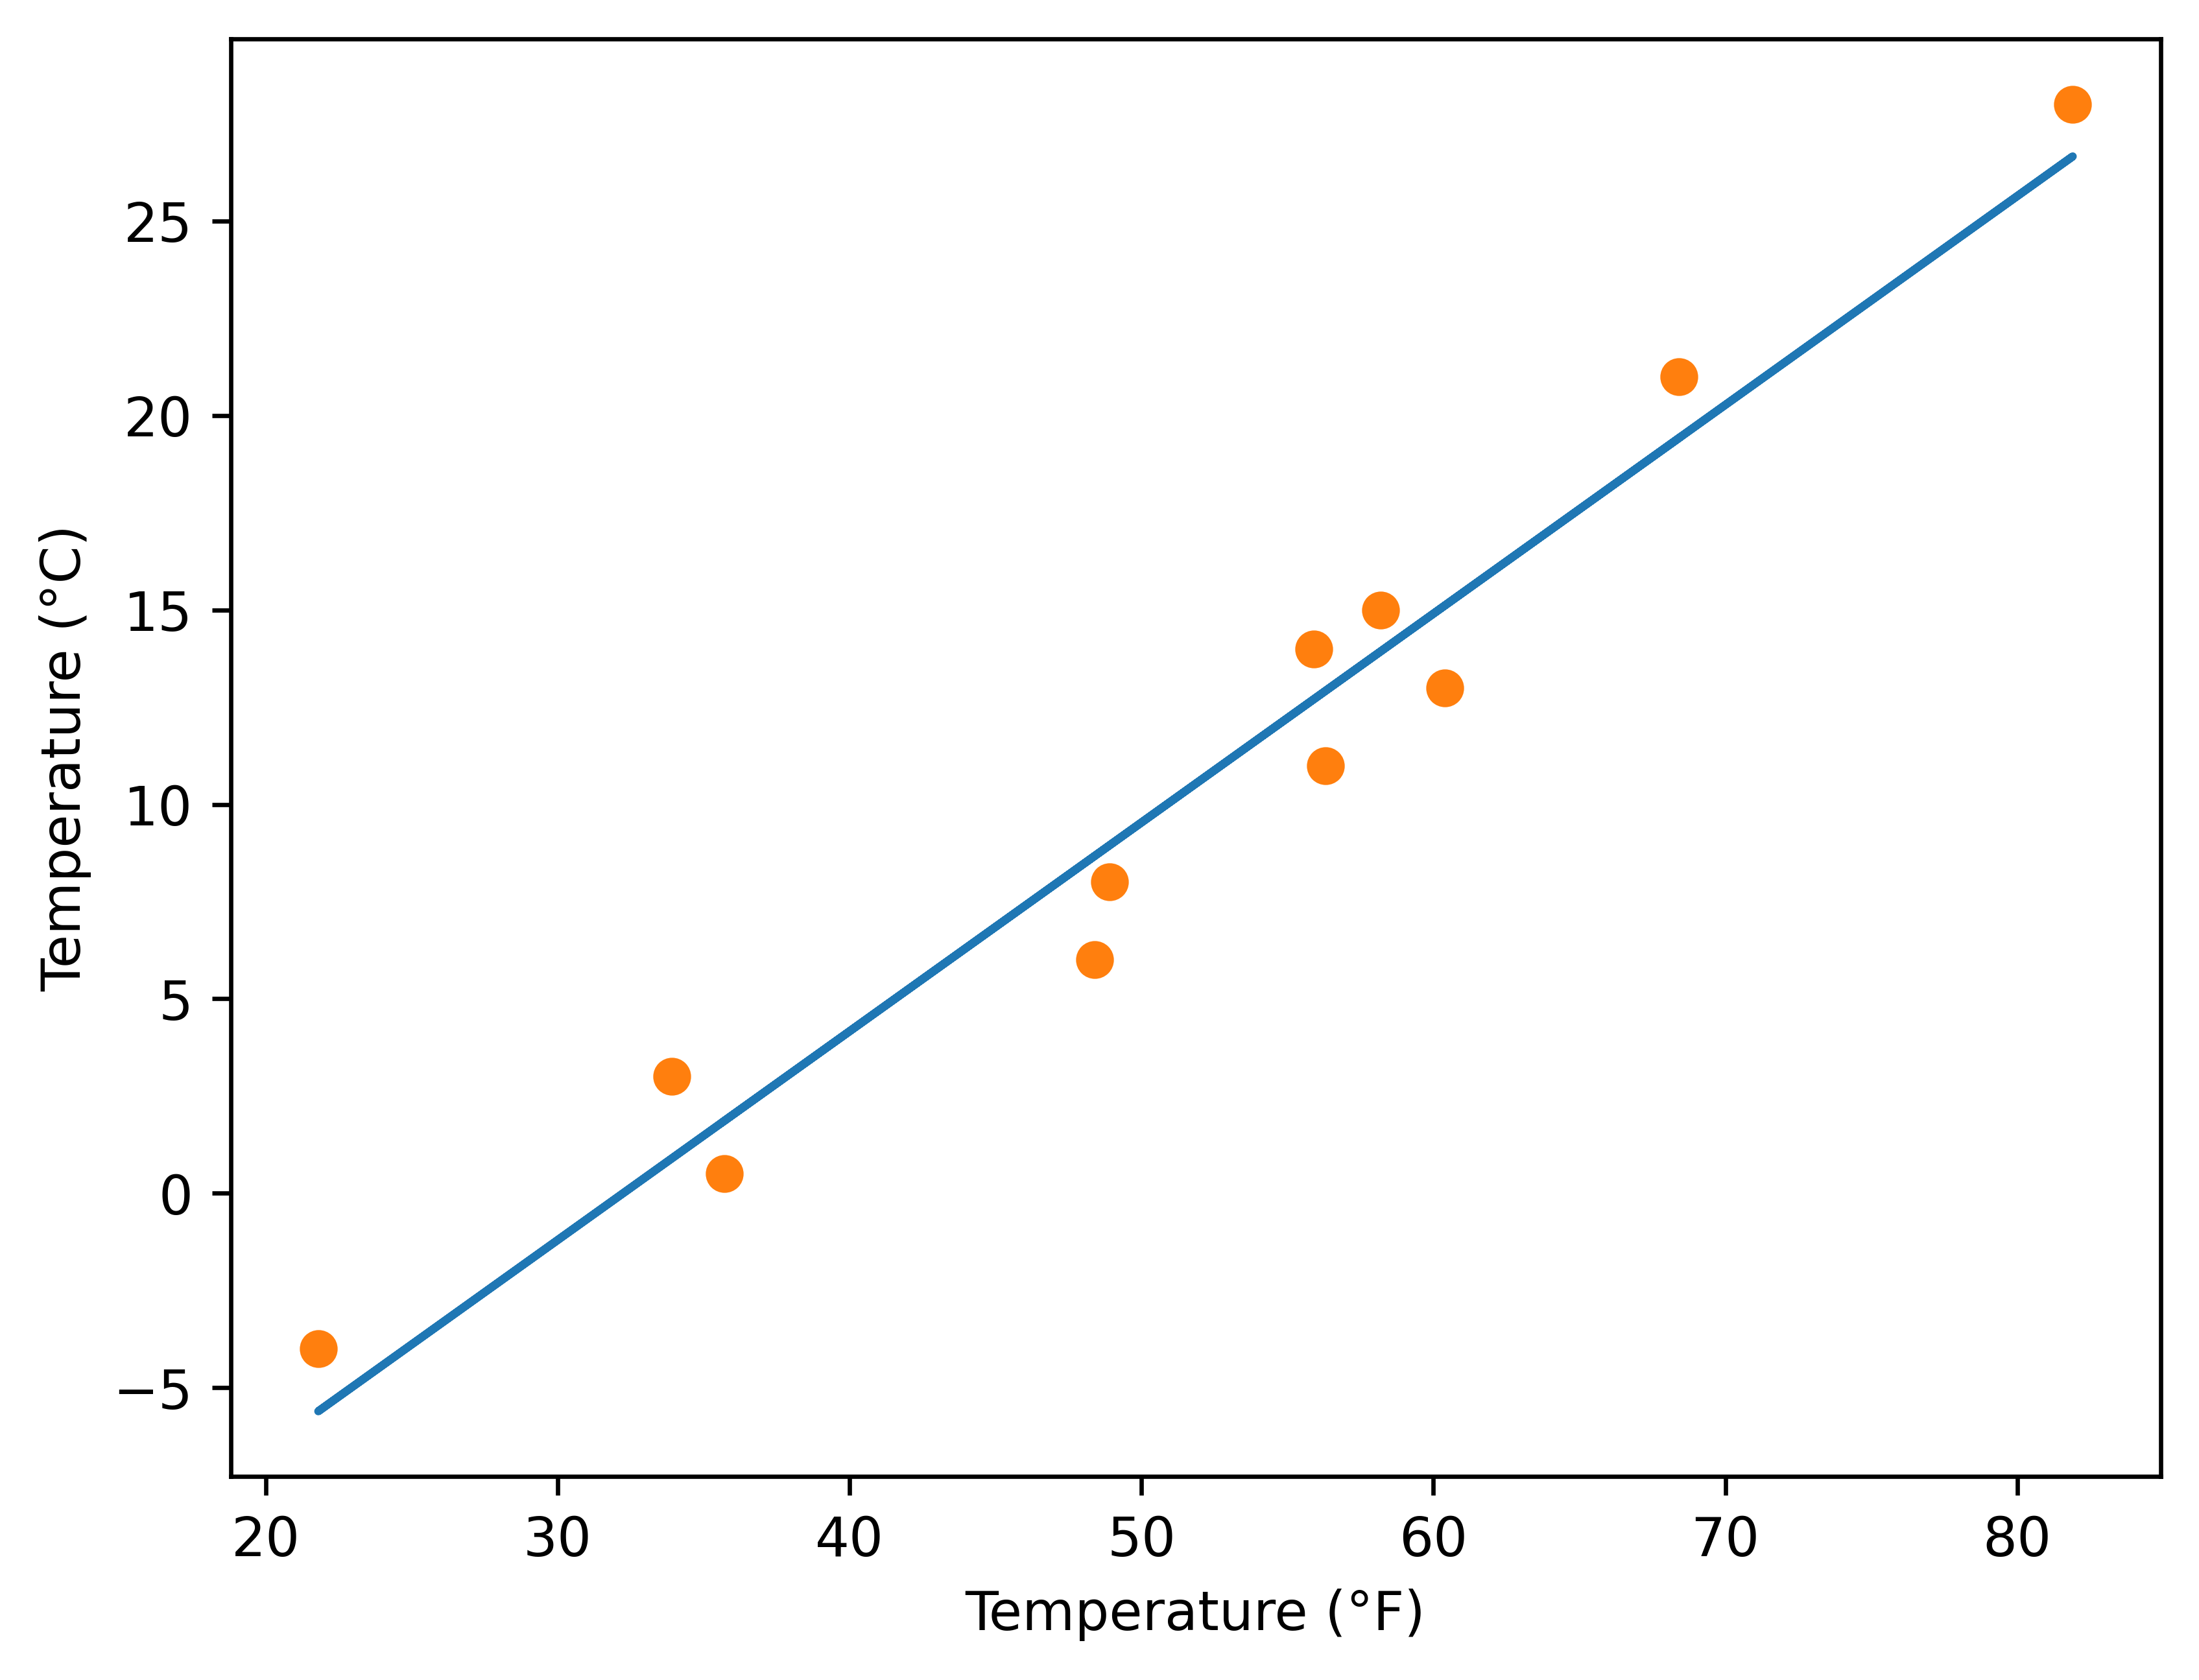

In [393]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)

fig = plt.figure(dpi=600)
plt.xlabel('Temperature (°F)')
plt.ylabel('Temperature (°C)')
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')